# Ray13 et al 2013 Sandbox 
**Authorship:**
Adam Klie, *08/31/2022*
***
**Description:**
Notebook to test things out as we get Ray13 working
***

In [177]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
from tqdm.auto import tqdm
from itertools import product
tqdm.pandas()
from sklearn.metrics import r2_score, auc
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
eu.settings.dataset_dir = "../../../_datasets/ray13"
eu.settings.output_dir = "../../../_output/ray13"
eu.settings.logging_dir = "../../../_logs/ray13"
eu.settings.config_dir = "../../../_configs/ray13"
eu.settings.verbosity = logging.ERROR

## Function definitions for testing

In [ ]:
def generate_all_possible_kmers(n=7, alphabet="AGCU"):
    """
    Generate all possible kmers of length and alphabet provided
    """
    return [''.join(c) for c in product(alphabet, repeat=n)]

In [ ]:
def kmer_in_seqs(seqs, kmer):
    """
    Return a 0/1 array of whether a kmer is in each of the passed in sequences
    """
    seqs_s = pd.Series(seqs)
    kmer_binary = seqs_s.str.contains(kmer).astype(int).values
    return kmer_binary

In [ ]:
def calc_auc(z, y, want_curve = False):
    # https://github.com/jisraeli/DeepBind/blob/master/code/deepfind.py
   """Given predictions z and 0/1 targets y, computes AUC with optional ROC curve"""
   z = z.ravel()
   y = y.ravel()
   assert len(z) == len(y)

# Remove any pair with NaN in y    
   m = ~np.isnan(y)
   y = y[m]
   z = z[m]
   assert np.all(np.logical_or(y==0, y==1)), "Cannot calculate AUC for non-binary targets"

   order = np.argsort(z,axis=0)[::-1].ravel()   # Sort by decreasing order of prediction strength
   z = z[order]
   y = y[order]
   npos = np.count_nonzero(y)      # Total number of positives.
   nneg = len(y)-npos              # Total number of negatives.
   if nneg == 0 or npos == 0:
       return (np.nan,None) if want_curve else 1

   n = len(y)
   fprate = np.zeros((n+1,1))
   tprate = np.zeros((n+1,1))
   ntpos,nfpos = 0.,0.
   for i,yi in enumerate(y):
       if yi: ntpos += 1
       else:  nfpos += 1
       tprate[i+1] = ntpos/npos
       fprate[i+1] = nfpos/nneg
   auc = float(np.trapz(tprate,fprate,axis=0))
   if want_curve:
       curve = np.hstack([fprate,tprate])
       return auc, curve
   return auc

In [ ]:
def median_calc(preds, y):
    nan_mask = (~np.isnan(y))
    y = y[nan_mask]
    preds = preds[nan_mask]
    indeces_1 = np.where(preds==1)[0]
    return np.median(y[indeces_1])


In [ ]:
def auc_calc(preds, y):
    nan_mask = (~np.isnan(y))
    y = y[nan_mask]a
    preds = preds[nan_mask]
    order = np.argsort(y)
    y_sorted = y[order]
    preds_sorted = preds[order]
    return auc(y_sorted, preds_sorted)

In [ ]:
def escore(preds, y, use_calc_auc=False):
    nan_mask = (~np.isnan(y))
    y = y[nan_mask]
    preds = preds[nan_mask]
    l_0 = np.where(preds == 0)[0]
    l_1 = np.where(preds == 1)[0]
    y_0 = y[l_0]
    y_1 = y[l_1]
    indeces_y_0, indeces_y_1 = np.argsort(y_0)[::-1], np.argsort(y_1)[::-1]
    sorted_y_0, sorted_y_1 = np.sort(y_0)[::-1], np.sort(y_1)[::-1]
    indeces_y_0_top = indeces_y_0[:int(len(sorted_y_0)/2)]
    indeces_y_1_top = indeces_y_1[:int(len(sorted_y_1)/2)]
    sorted_y_0_top = sorted_y_0[:int(len(sorted_y_0)/2)]
    sorted_y_1_top = sorted_y_1[:int(len(sorted_y_1)/2)]
    l_0_top = l_0[indeces_y_0_top]
    l_1_top = l_1[indeces_y_1_top]
    l_top = np.concatenate([l_0_top, l_1_top])
    if use_calc_auc:
        print("HERE")
        return calc_auc(y[l_top], preds[l_top])
    else:
        return auc_calc(preds=preds[l_top], y=y[l_top])

In [ ]:
def rna_complete_metrics(probes, intensities, n=7, alphabet="AGCU", num_kmers=None):
    possible_kmers = generate_all_possible_kmers(n=n, alphabet=alphabet)
    num_kmers = len(possible_kmers) if num_kmers is None else num_kmers
    possible_kmers = possible_kmers[:num_kmers]
    kmer_medians, kmer_aucs, kmer_escores = [], [], []
    y = intensities
    for i, kmer in tqdm(enumerate(possible_kmers), desc="Scoring k-mers", total=len(possible_kmers)):
        preds = kmer_in_seqs(seqs=probes, kmer=kmer)
        kmer_medians.append(median_calc(preds=preds, y=y))
        kmer_aucs.append(auc_calc(preds=preds, y=y))
        kmer_escores.append(escore(preds=preds, y=y))
    kmer_medians, kmer_aucs, kmer_escore = np.array(kmer_medians), np.array(kmer_aucs), np.array(kmer_escores)
    kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)
    return kmer_zscores, kmer_aucs, kmer_escores

In [ ]:
def rna_complete(kmer_presence_mtx, intensities, num_kmers=None, use_calc_auc=False, verbose=True):
    y = intensities
    num_kmers = len(kmer_presence_mtx) if num_kmers is None else num_kmers
    kmer_presence_mtx = kmer_presence_mtx[:num_kmers]
    preds = kmer_presence
        kmer_medians.append(median_calc(preds=preds, y=y))
        if use_calc_auc:
            kmer_aucs.append(calc_auc(y, preds))
        else:
            kmer_aucs.append(auc_calc(preds=preds, y=y))
        kmer_escores.append(escore(preds=preds, y=y, use_calc_auc=use_calc_auc))
    kmer_medians, kmer_aucs, kmer_escore = np.array(kmer_medians), np.array(kmer_aucs), np.array(kmer_escores)
    kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)
    return kmer_zscores, kmer_aucs, kmer_escores

In [ ]:
def rna_complete_metrics_2(kmer_presence_mtx, intensities, num_kmers=None, use_calc_auc=False, verbose=True):
    y = intensities
    num_kmers = len(kmer_presence_mtx) if num_kmers is None else num_kmers
    kmer_presence_mtx = kmer_presence_mtx[:num_kmers]
    kmer_medians, kmer_aucs, kmer_escores = [], [], []
    for i, kmer_presence in tqdm(enumerate(kmer_presence_mtx), desc="Scoring k-mers", total=len(kmer_presence_mtx), disable = not verbose):
        preds = kmer_presence
        kmer_medians.append(median_calc(preds=preds, y=y))
        if use_calc_auc:
            kmer_aucs.append(calc_auc(y, preds))
        else:
            kmer_aucs.append(auc_calc(preds=preds, y=y))
        kmer_escores.append(escore(preds=preds, y=y, use_calc_auc=use_calc_auc))
    kmer_medians, kmer_aucs, kmer_escore = np.array(kmer_medians), np.array(kmer_aucs), np.array(kmer_escores)
    kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)
    return kmer_zscores, kmer_aucs, kmer_escores

In [ ]:
def column_rnac_metrics(sdata, kmer_presence_mtx, probe_id, n_kmers=None, return_cors=False, verbose=True, use_calc_auc=False):
    observed = sdata[probe_id].values
    preds = sdata[f"{probe_id}_predictions"].values
    
    # Get zscores, aucs and escores from observed intensities
    observed_zscores, observed_aucs, observed_escores = rna_complete_metrics_2(kmer_presence_mtx, observed, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)

    # Get zscores, aucs, and escores from predicted intensities
    preds_zscores, preds_aucs, preds_escores = rna_complete_metrics_2(kmer_presence_mtx, preds, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)
    
    # Z-scores
    zscore_pearson = pearsonr(preds_zscores, observed_zscores)[0]
    zscore_spearman = spearmanr(preds_zscores, observed_zscores).correlation

    # AUCs
    auc_pearson = pearsonr(preds_aucs, observed_aucs)[0]
    auc_spearman = spearmanr(preds_aucs, observed_aucs).correlation

    # E-scores
    escore_pearson = pearsonr(preds_escores, observed_escores)[0]
    escore_spearman = spearmanr(preds_escores, observed_escores).correlation

    # Intensities
    intensity_pearson = pearsonr(observed, preds)[0]
    intensity_spearman = spearmanr(observed, preds).correlation
    
    if return_cors:
        pearson = {"Z-score": zscore_pearson, "AUC": auc_pearson, "E-score": escore_pearson, "Intensity": intensity_pearson}
        spearman = {"Z-score": zscore_spearman, "AUC": auc_spearman, "E-score": escore_spearman, "Intensity": intensity_spearman}
        return pearson, spearman
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].scatter(observed_zscores, preds_zscores)
    ax[0].set_title("Z-scores")
    ax[0].set_xlabel("Observed")
    ax[0].set_ylabel("Predicted")
    ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

    ax[1].scatter(observed_aucs, preds_aucs)
    ax[1].set_title("AUCs")
    ax[1].set_xlabel("Observed")
    ax[1].set_ylabel("Predicted")
    ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

    ax[2].scatter(observed_escores, preds_escores)
    ax[2].set_title("E-scores")
    ax[2].set_xlabel("Observed")
    ax[2].set_ylabel("Predicted")
    ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

    ax[3].scatter(observed, preds)
    ax[3].set_title("Intensities")
    ax[3].set_xlabel("Observed")
    ax[3].set_ylabel("Predicted")
    ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

    plt.tight_layout()

SyntaxError: invalid syntax (1524864938.py, line 1)

In [ ]:
def summarize_rbps(probe_ids, seqs, n_kmers=100, verbose=False, use_calc_auc=False):
    spearman_summary = pd.DataFrame()
    pearson_summary = pd.DataFrame()
    for i, probe_id in tqdm(enumerate(probe_ids), desc="Evaluating probes", total=len(probe_ids)):
        rs, rhos = evaluate_rbp(probe_id, sdata.seqs, n_kmers=n_kmers, return_cors=True, verbose=verbose, use_calc_auc=use_calc_auc)
        pearson_summary = pd.concat([pearson_summary, pd.DataFrame(rs, index=[probe_id])], axis=0)
        spearman_summary = pd.concat([spearman_summary, pd.DataFrame(rhos, index=[probe_id])], axis=0)
    return pearson_summary, spearman_summary

In [ ]:
def rna_complete_metrics_apply(kmer_presence_mtx, intensities, num_kmers=None, use_calc_auc=False, verbose=True):
    df = pd.DataFrame(kmer_presence_mtx)
    y = intensities
    df_sub = df[:num_kmers]
    if verbose:
        if use_calc_auc:
            rbp_eval = df_sub.progress_apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': calc_auc(y, preds), 'E-score': escore(preds, y, use_calc_auc=True)}), axis=1)
        else:
            rbp_eval = df_sub.progress_apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': auc_calc(preds, y), 'E-score': escore(preds, y)}), axis=1)
    else:
        if use_calc_auc:
            rbp_eval = df_sub.apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': calc_auc(y, preds), 'E-score': escore(preds, y, use_calc_auc=True)}), axis=1)
        else:
            rbp_eval = df_sub.apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': auc_calc(preds, y), 'E-score': escore(preds, y)}), axis=1)
    rbp_eval["Z-score"] = (rbp_eval["Median"] - np.mean(rbp_eval["Median"])) / np.std(rbp_eval["Median"], ddof=1)
    return rbp_eval["Z-score"].values, rbp_eval["AUC"].values, rbp_eval["E-score"].values, 

In [ ]:
def column_rnac_metrics_apply(sdata, kmer_presence_mtx, probe_id, n_kmers=None, return_cors=False, use_calc_auc=False, verbose=True):
    observed = sdata[probe_id].values
    preds = sdata[f"{probe_id}_predictions"].values
    
    # Get zscores, aucs and escores from observed intensities
    observed_zscores, observed_aucs, observed_escores = rna_complete_metrics_apply(kmer_presence_mtx, observed, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)

    # Get zscores, aucs, and escores from predicted intensities
    preds_zscores, preds_aucs, preds_escores = rna_complete_metrics_apply(kmer_presence_mtx, preds, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)
    
    # Z-scores
    zscore_pearson = pearsonr(preds_zscores, observed_zscores)[0]
    zscore_spearman = spearmanr(preds_zscores, observed_zscores).correlation

    # AUCs
    auc_pearson = pearsonr(preds_aucs, observed_aucs)[0]
    auc_spearman = spearmanr(preds_aucs, observed_aucs).correlation

    # E-scores
    escore_pearson = pearsonr(preds_escores, observed_escores)[0]
    escore_spearman = spearmanr(preds_escores, observed_escores).correlation

    # Intensities
    intensity_pearson = pearsonr(observed, preds)[0]
    intensity_spearman = spearmanr(observed, preds).correlation
    
    if return_cors:
        pearson = {"Z-score": zscore_pearson, "AUC": auc_pearson, "E-score": escore_pearson, "Intensity": intensity_pearson}
        spearman = {"Z-score": zscore_spearman, "AUC": auc_spearman, "E-score": escore_spearman, "Intensity": intensity_spearman}
        return pearson, spearman
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].scatter(observed_zscores, preds_zscores)
    ax[0].set_title("Z-scores")
    ax[0].set_xlabel("Observed")
    ax[0].set_ylabel("Predicted")
    ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

    ax[1].scatter(observed_aucs, preds_aucs)
    ax[1].set_title("AUCs")
    ax[1].set_xlabel("Observed")
    ax[1].set_ylabel("Predicted")
    ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

    ax[2].scatter(observed_escores, preds_escores)
    ax[2].set_title("E-scores")
    ax[2].set_xlabel("Observed")
    ax[2].set_ylabel("Predicted")
    ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

    ax[3].scatter(observed, preds)
    ax[3].set_title("Intensities")
    ax[3].set_xlabel("Observed")
    ax[3].set_ylabel("Predicted")
    ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

    plt.tight_layout()

In [ ]:
def summarize_rbps_apply(sdata, kmer_presence_mtx, probe_ids, n_kmers=100, verbose=False, use_calc_auc=False):
    spearman_summary = pd.DataFrame()
    pearson_summary = pd.DataFrame()
    for i, probe_id in tqdm(enumerate(probe_ids), desc="Evaluating probes", total=len(probe_ids)):
        rs, rhos = column_rnac_metrics_apply(sdata, kmer_presence_mtx, probe_id=probe_id, n_kmers=n_kmers, return_cors=True, verbose=verbose, use_calc_auc=use_calc_auc)
        pearson_summary = pd.concat([pearson_summary, pd.DataFrame(rs, index=[probe_id])], axis=0)
        spearman_summary = pd.concat([spearman_summary, pd.DataFrame(rhos, index=[probe_id])], axis=0)
    return pearson_summary, spearman_summary

# Working with predictions sent by Hayden on 08/24/2022
Muiltitask model trained on the whole dataset

In [178]:
# This dataset wasn't originally split on Set, so I manually did it
sdata = eu.dl.read_h5sd("../../output/ray13/sequence_datum/SD_predict_RNAcomplete.h5")
sdata_set_a = sdata[:120326]
sdata_set_b = sdata[120326:]

In [305]:
# For apply functions, we want preloaded kmer presence matrices
a_presence_absence = np.load("/cellar/users/aklie/data/eugene/ray13/SetA_binary.npy")
b_presence_absence = np.load("/cellar/users/aklie/data/eugene/ray13/SetB_binary.npy")

# Testing out the pandas apply versions of eval metrics

In [199]:
# Choose the task
probe_id = "RNCMPT00001"
observed = sdata_set_a[probe_id].values
preds = sdata_set_a[f"{probe_id}_predictions"].values

In [292]:
# Test the apply version of teh functions
metr = rna_complete_metrics_apply(a_presence_absence, observed, num_kmers=100, verbose=False)
metr = rna_complete_metrics_apply(a_presence_absence, observed, num_kmers=100, verbose=True)
column_rnac_metrics_apply(sdata=sdata_set_a, kmer_presence_mtx=a_presence_absence, probe_id=probe_id, n_kmers=100, verbose=True)
column_rnac_metrics_apply(sdata=sdata_set_a, kmer_presence_mtx=a_presence_absence, probe_id=probe_id, n_kmers=100, use_calc_auc=True, verbose=False)

In [303]:
# Try to get all the targets z-scores etc
all_probe_ids = sdata_set_b.seqs_annot.columns[~sdata_set_b.seqs_annot.columns.str.contains("predictions")][:-1]
pearson_df, spearman_df = summarize_rbps_apply(sdata_set_b, b_presence_absence, all_probe_ids, n_kmers=None, use_calc_auc=True, verbose=True)

In [300]:
# Make Seaborn plottable dfs
pearson_long = pearson_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_long = spearman_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)

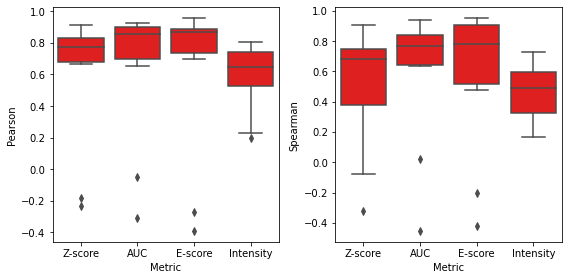

In [301]:
# Plot the results!
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()

# Testing out the original for loop versions of eval metrics

In [164]:
# Choose the task
probe_id = "RNCMPT00001"
observed = sdata[probe_id].values
preds = sdata[f"{probe_id}_predictions"].values

In [3]:
# Function calculates metrics on a single column or task
evaluate_rbp(probe_id, sdata.seqs, n_kmers=10, verbose=True, use_calc_auc=True)

In [167]:
# Get all columns for each rbp
all_probe_ids = sdata.seqs_annot.columns[~sdata.seqs_annot.columns.str.contains("predictions")][:-1]

In [169]:
# Calc metrics for 10 of them
pearson_df, spearman_df = summarize_rbps(all_probe_ids[:10], sdata.seqs, n_kmers=5, use_calc_auc=True)

Evaluating probes:   0%|          | 0/10 [00:00<?, ?it/s]

In [171]:
# Make Seaborn plottable dfs
pearson_long = pearson_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_long = spearman_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)

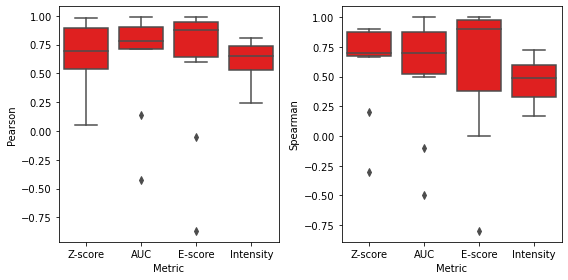

In [173]:
# Plot the results!
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()

---

# Scratch

## Developing evaluate RBP

In [2]:
def evaluate_rbp(sdata, probe_id, n_kmers=100, return_cors=False, verbose=True, use_calc_auc=False):
    seqs = sdata.seqs
    observed = sdata[probe_id].values
    preds = sdata[f"{probe_id}_predictions"].values
    
    # Get zscores, aucs and escores from observed intensities
    observed_zscores, observed_aucs, observed_escores = eu.predict.rna_complete_metrics(seqs, observed, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)

    # Get zscores, aucs, and escores from predicted intensities
    preds_zscores, preds_aucs, preds_escores = eu.predict.rna_complete_metrics(seqs, preds, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)
    
    # Z-scores
    zscore_pearson = pearsonr(preds_zscores, observed_zscores)[0]
    zscore_spearman = spearmanr(preds_zscores, observed_zscores).correlation

    # AUCs
    auc_pearson = pearsonr(preds_aucs, observed_aucs)[0]
    auc_spearman = spearmanr(preds_aucs, observed_aucs).correlation

    # E-scores
    escore_pearson = pearsonr(preds_escores, observed_escores)[0]
    escore_spearman = spearmanr(preds_escores, observed_escores).correlation

    # Intensities
    intensity_pearson = pearsonr(observed, preds)[0]
    intensity_spearman = spearmanr(observed, preds).correlation
    
    if return_cors:
        pearson = {"Z-score": zscore_pearson, "AUC": auc_pearson, "E-score": escore_pearson, "Intensity": intensity_pearson}
        spearman = {"Z-score": zscore_spearman, "AUC": auc_spearman, "E-score": escore_spearman, "Intensity": intensity_spearman}
        return pearson, spearman
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].scatter(observed_zscores, preds_zscores)
    ax[0].set_title("Z-scores")
    ax[0].set_xlabel("Observed")
    ax[0].set_ylabel("Predicted")
    ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

    ax[1].scatter(observed_aucs, preds_aucs)
    ax[1].set_title("AUCs")
    ax[1].set_xlabel("Observed")
    ax[1].set_ylabel("Predicted")
    ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

    ax[2].scatter(observed_escores, preds_escores)
    ax[2].set_title("E-scores")
    ax[2].set_xlabel("Observed")
    ax[2].set_ylabel("Predicted")
    ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

    ax[3].scatter(observed, preds)
    ax[3].set_title("Intensities")
    ax[3].set_xlabel("Observed")
    ax[3].set_ylabel("Predicted")
    ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

    plt.tight_layout()

In [90]:
# Get zscores, aucs and escores from observed intensities
observed_zscores, observed_aucs, observed_escores = eu.predict.rna_complete_metrics(sdata.seqs, observed, num_kmers=100)

# Get zscores, aucs, and escores from predicted intensities
db_zscores, db_aucs, db_escores = eu.predict.rna_complete_metrics(sdata.seqs, preds, num_kmers=100)

# Z-scores
zscore_pearson = pearsonr(db_zscores, observed_zscores)[0]
zscore_spearman = spearmanr(db_zscores, observed_zscores).correlation

# AUCs
auc_pearson = pearsonr(db_aucs, observed_aucs)[0]
auc_spearman = spearmanr(db_aucs, observed_aucs).correlation

# E-scores
escore_pearson = pearsonr(db_escores, observed_escores)[0]
escore_spearman = spearmanr(db_escores, observed_escores).correlation

# Intensities
intensity_pearson = pearsonr(observed, preds)[0]
intensity_spearman = spearmanr(observed, preds).correlation

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].scatter(observed_zscores, db_zscores)
ax[0].set_title("Z-scores")
ax[0].set_xlabel("Observed")
ax[0].set_ylabel("Predicted")
ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

ax[1].scatter(observed_aucs, db_aucs)
ax[1].set_title("AUCs")
ax[1].set_xlabel("Observed")
ax[1].set_ylabel("Predicted")
ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

ax[2].scatter(observed_escores, db_escores)
ax[2].set_title("E-scores")
ax[2].set_xlabel("Observed")
ax[2].set_ylabel("Predicted")
ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

ax[3].scatter(observed, preds)
ax[3].set_title("Intensities")
ax[3].set_xlabel("Observed")
ax[3].set_ylabel("Predicted")
ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

plt.tight_layout()

In [ ]:
# Test out above
df = pd.DataFrame(a_presence_absence)
df_sub = df[:100]
rbp_eval = df_sub.progress_apply(lambda x: pd.Series({'Median': median_calc(x, preds), 'AUC': auc_calc(x, preds), 'E-score': escore(x, preds)}), axis=1)
rbp_eval["Z-score"] = (rbp_eval["Median"] - np.mean(rbp_eval["Median"])) / np.std(rbp_eval["Median"], ddof=1)
rbp_eval

## Developing DeepBind Evaluation Metrics

In [ ]:
# Older attempts
def rna_complete_zscores(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")
    probes_s = pd.Series(probes)
    kmer_indeces = [np.where(probes_s.str.contains(kmer))[0] for kmer in kmers]
    median_kmer_intensities = [np.nanmedian(values[l]) for l in kmer_indeces]
    z_scores = (median_kmer_intensities - np.mean(median_kmer_intensities))/np.std(median_kmer_intensities, ddof=1)
    return z_scores


def rna_complete_zscores(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")[:10]
    probes_s = pd.Series(probes)
    kmer_indeces = [np.where(probes_s.str.contains(kmer))[0] for kmer in kmers[:10]]
    median_kmer_intensities = [np.nanmedian(values[l]) for l in kmer_indeces]
    z_scores = (median_kmer_intensities - np.mean(median_kmer_intensities))/np.std(median_kmer_intensities, ddof=1)
    return z_scores


def rna_complete_aucs(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")[:10]
    kmers_in_probes(probes, kmers):
    order = np.argsort(values)
    true_sorted = values[order]
    preds_sorted = kmer_hits[:, order]
    nan_mask = (~np.isnan(true_sorted))
    true_cleaned = true_sorted[nan_mask]
    preds_cleaned = preds_sorted[:, nan_mask]
    aucs = np.array([auc(true_cleaned, preds) for preds in preds_cleaned])
    return aucs


def rna_complete_aucs(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")[:10]
    probes_s = pd.Series(probes)
    kmer_hits = np.array([probes_s.str.contains(kmer).astype(int).values for kmer in kmers[:10]])
    order = np.argsort(values)
    true_sorted = values[order]
    preds_sorted = kmer_hits[:, order]
    nan_mask = (~np.isnan(true_sorted))
    true_cleaned = true_sorted[nan_mask]
    preds_cleaned = preds_sorted[:, nan_mask]
    aucs = np.array([auc(true_cleaned, preds) for preds in preds_cleaned])
    return aucs


def rna_complete_aucs(kmer_binary, values):
    nan_mask = (~np.isnan(values))
    true = values[nan_mask]
    preds = kmer_binary[:, nan_mask]
    order = np.argsort(true)
    true_sorted = true[order]
    preds_sorted = preds[:, order]
    aucs = np.array([auc(true_sorted, preds) for preds in preds_sorted])
    return aucs

rna_complete_zscores(probes=sdata.seqs, values=sdata["RNCMPT00100"])
rna_complete_aucs(k_binary, sdata["RNCMPT00100"].values)
rna_complete_aucs(probes=sdata.seqs, values=sdata["RNCMPT00100"].values)

In [ ]:
# Get the hits for k-mers
possible_kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")
k_binary = kmer_in_seqs(seqs=sdata.seqs, kmer=possible_kmers[0])
np.unique(k_binary, return_counts=True)

# Real data
preds = k_binary
y = sdata["RNCMPT00100"].values

# Pretend data
#preds = np.array([0, 1, 1, 1, 0, 0, 0, 1])
#y = np.array([0.2, 0.6, 0.8, 0.7, 0.5, 0.3, 0.1, 0.9])

median_calc(preds=preds, y=y), calc_auc(y, preds), auc_calc(preds=preds, y=y), escore(preds=preds, y=y), escore(preds, y, use_calc_auc=True)
rna_complete_metrics(probes=sdata.seqs, intensities=sdata["RNCMPT00100"].values, n=7, alphabet="AGCU", num_kmers=100)

In [ ]:
# Implementing the escore function

# Pull out one k-mers worth of hits and actuall probe intensities
preds = k_binary
y = sdata["RNCMPT00100"].values

preds = np.array([0, 1, 1, 1, 0, 0, 0, 1])
y = np.array([0.2, 0.6, 0.8, 0.7, 0.5, 0.3, 0.1, 0.9])

# Get the indices where the 7mers are hits and where they are not
l_0 = np.where(preds == 0)[0]
l_1 = np.where(preds == 1)[0]
l_0, l_1

# Get the probe intensities for k-mer hits and not
y_0 = y[l_0]
y_1 = y[l_1]
y_0, y_1

indeces_y_0, indeces_y_1 = np.argsort(y_0)[::-1], np.argsort(y_1)[::-1]
indeces_y_0, indeces_y_1

sorted_y_0, sorted_y_1 = np.sort(y_0)[::-1], np.sort(y_1)[::-1]
sorted_y_0, sorted_y_1

indeces_y_0_top = indeces_y_0[:int(len(sorted_y_0)/2)]
indeces_y_1_top = indeces_y_1[:int(len(sorted_y_1)/2)]
indeces_y_0_top, indeces_y_1_top

sorted_y_0_top = sorted_y_0[:int(len(sorted_y_0)/2)]
sorted_y_1_top = sorted_y_1[:int(len(sorted_y_1)/2)]
sorted_y_0_top, sorted_y_1_top

l_0_top = l_0[indeces_y_0_top]
l_1_top = l_1[indeces_y_1_top]
l_0_top, l_1_top

l_top = np.concatenate([l_0_top, l_1_top])
l_top

preds[l_top], y[l_top]

rna_complete_auc(preds=preds, y=y), rna_complete_auc(preds=preds[l_top], y=y[l_top])

In [ ]:
# Implementing the rnacomplete_metrics function
kmer_medians = []
kmer_aucs = []
kmer_escores = []
y = sdata["RNCMPT00100"].values
for i, kmer in tqdm(enumerate(possible_kmers[:n]), desc="Scoring k-mers", total=len(possible_kmers[:n])):
    preds = kmer_in_seqs(seqs=sdata.seqs, kmer=kmer)
    kmer_medians.append(median_calc(preds=preds, y=y))
    kmer_aucs.append(auc_calc(preds=preds, y=y))
    kmer_escores.append(escores(preds=preds, y=y))
kmer_medians = np.array(kmer_medians)
kmer_aucs = np.array(kmer_aucs)
kmer_escore = np.array(kmer_escores)
kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)

Scoring k-mers:   0%|          | 0/10 [00:00<?, ?it/s]